<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install transformers --quiet
!pip install wget --quiet

In [68]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [69]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 128
        self.n_hidden=64
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.out_features,  self.n_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3), # 20% Probability
            torch.nn.Linear( self.n_hidden, n_classes)
        )
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=8, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            eps = 1e-8,
            weight_decay=0.01,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [70]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [71]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [72]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42) # .15 .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941 .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11529,)
(8646,)
(2883,)
(2883,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/7


100%|██████████| 1081/1081 [01:19<00:00, 13.62it/s]


Train loss 0.5230908353470962 accuracy 0.7181355540134166
Valid:
Accuracy: 85.33 %
Recall: 81.23 %
precision: 0.8342881911725906, recall: 0.8432607643928398, f1score: 0.8383538699945244
Test:
Accuracy: 86.4 %
Recall: 82.0 %
precision: 0.8430050032769065, recall: 0.8526546825490737, f1score: 0.8474291805583906
*********************
              precision    recall  f1-score   support

           0     0.9106    0.8853    0.8978      1944
           1     0.7754    0.8200    0.7971       939

    accuracy                         0.8640      2883
   macro avg     0.8430    0.8527    0.8474      2883
weighted avg     0.8666    0.8640    0.8650      2883

Accuracy: 86.4 %
Recall: 82.0 %
Precision: 77.54 %
F1-score: 79.71 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1721
False Positives:  223
False Negatives:  169
True Positives:  770
Epoch 2/7


100%|██████████| 1081/1081 [01:19<00:00, 13.60it/s]


Train loss 0.3422435368777397 accuracy 0.8761276891047883
Valid:
Accuracy: 86.85 %
Recall: 76.82 %
precision: 0.8581465720352215, recall: 0.8440082244799225, f1score: 0.8503138436854464
Test:
Accuracy: 88.48 %
Recall: 77.53 %
precision: 0.8768714538360243, recall: 0.8565250331979122, f1score: 0.8654293243712905
*********************
              precision    recall  f1-score   support

           0     0.8963    0.9378    0.9165      1944
           1     0.8575    0.7753    0.8143       939

    accuracy                         0.8848      2883
   macro avg     0.8769    0.8565    0.8654      2883
weighted avg     0.8836    0.8848    0.8832      2883

Accuracy: 88.48 %
Recall: 77.53 %
Precision: 85.75 %
F1-score: 81.43 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1823
False Positives:  121
False Negatives:  211
True Positives:  728
Epoch 3/7


100%|██████████| 1081/1081 [01:19<00:00, 13.57it/s]


Train loss 0.3045592556193223 accuracy 0.8997224149895906
Valid:
Accuracy: 87.96 %
Recall: 83.38 %
precision: 0.8643438069773499, recall: 0.8684429930656345, f1score: 0.8663206918498598
Test:
Accuracy: 89.07 %
Recall: 83.92 %
precision: 0.8747666337379074, recall: 0.8774142442051565, f1score: 0.8760655737704918
*********************
              precision    recall  f1-score   support

           0     0.9218    0.9156    0.9187      1944
           1     0.8277    0.8392    0.8334       939

    accuracy                         0.8907      2883
   macro avg     0.8748    0.8774    0.8761      2883
weighted avg     0.8912    0.8907    0.8909      2883

Accuracy: 89.07 %
Recall: 83.92 %
Precision: 82.77 %
F1-score: 83.34 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1780
False Positives:  164
False Negatives:  151
True Positives:  788
Epoch 4/7


100%|██████████| 1081/1081 [01:19<00:00, 13.59it/s]


Train loss 0.27011941267120604 accuracy 0.9153365718251214
Valid:
Accuracy: 87.55 %
Recall: 87.08 %
precision: 0.8573484539806906, recall: 0.8743259151749718, f1score: 0.8643412016101369
Test:
Accuracy: 89.25 %
Recall: 87.43 %
precision: 0.8736811820662933, recall: 0.8877844830986471, f1score: 0.8799545139993294
*********************
              precision    recall  f1-score   support

           0     0.9369    0.9012    0.9187      1944
           1     0.8105    0.8743    0.8412       939

    accuracy                         0.8925      2883
   macro avg     0.8737    0.8878    0.8800      2883
weighted avg     0.8957    0.8925    0.8935      2883

Accuracy: 89.25 %
Recall: 87.43 %
Precision: 81.05 %
F1-score: 84.12 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1752
False Positives:  192
False Negatives:  118
True Positives:  821
Epoch 5/7


100%|██████████| 1081/1081 [01:19<00:00, 13.55it/s]


Train loss 0.24895298502569074 accuracy 0.9273652556095304
Valid:
Accuracy: 88.62 %
Recall: 85.13 %
precision: 0.87090418146977, recall: 0.8776850507982583, f1score: 0.8740958189582173
Test:
Accuracy: 89.87 %
Recall: 84.88 %
precision: 0.8841289805998935, recall: 0.8858073995187946, f1score: 0.8849586207650512
*********************
              precision    recall  f1-score   support

           0     0.9267    0.9228    0.9247      1944
           1     0.8416    0.8488    0.8452       939

    accuracy                         0.8987      2883
   macro avg     0.8841    0.8858    0.8850      2883
weighted avg     0.8990    0.8987    0.8988      2883

Accuracy: 89.87 %
Recall: 84.88 %
Precision: 84.16 %
F1-score: 84.52 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1794
False Positives:  150
False Negatives:  142
True Positives:  797
Epoch 6/7


100%|██████████| 1081/1081 [01:19<00:00, 13.54it/s]


Train loss 0.2287487968256237 accuracy 0.9339578996067546
Valid:
Accuracy: 87.69 %
Recall: 88.1 %
precision: 0.8586727587209748, recall: 0.8778817932591518, f1score: 0.866311396810879
Test:
Accuracy: 89.39 %
Recall: 87.97 %
precision: 0.8749881542537286, recall: 0.890189688268318, f1score: 0.8816804684079964
*********************
              precision    recall  f1-score   support

           0     0.9394    0.9007    0.9196      1944
           1     0.8106    0.8797    0.8437       939

    accuracy                         0.8939      2883
   macro avg     0.8750    0.8902    0.8817      2883
weighted avg     0.8974    0.8939    0.8949      2883

Accuracy: 89.39 %
Recall: 87.97 %
Precision: 81.06 %
F1-score: 84.37 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1751
False Positives:  193
False Negatives:  113
True Positives:  826
Epoch 7/7


100%|██████████| 1081/1081 [01:19<00:00, 13.63it/s]


Train loss 0.2109123579709757 accuracy 0.9404348831829747
Valid:
Accuracy: 88.1 %
Recall: 87.18 %
precision: 0.863504813198378, recall: 0.8787695532978552, f1score: 0.8699898199981619
Test:
Accuracy: 89.42 %
Recall: 86.05 %
precision: 0.8769497456050037, recall: 0.885491855007297, f1score: 0.880952364834906
*********************
              precision    recall  f1-score   support

           0     0.9311    0.9105    0.9207      1944
           1     0.8228    0.8605    0.8412       939

    accuracy                         0.8942      2883
   macro avg     0.8769    0.8855    0.8810      2883
weighted avg     0.8958    0.8942    0.8948      2883

Accuracy: 89.42 %
Recall: 86.05 %
Precision: 82.28 %
F1-score: 84.12 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1770
False Positives:  174
False Negatives:  131
True Positives:  808
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

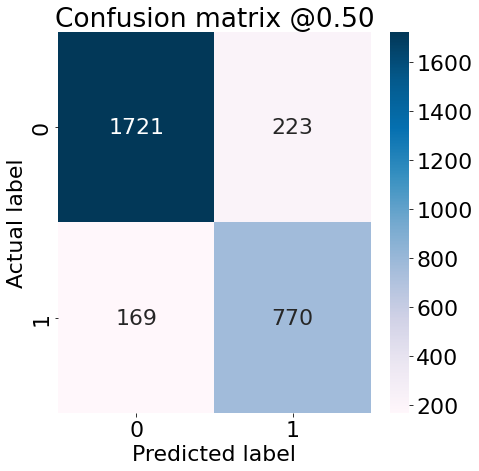

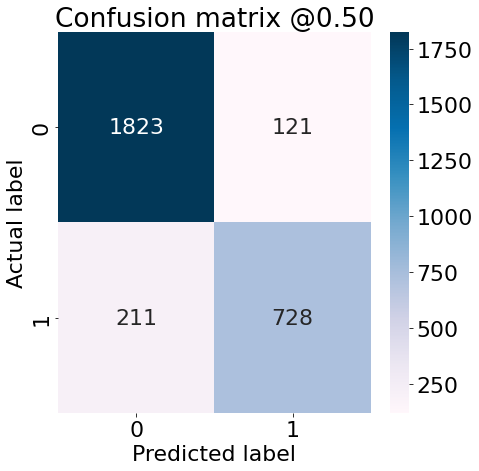

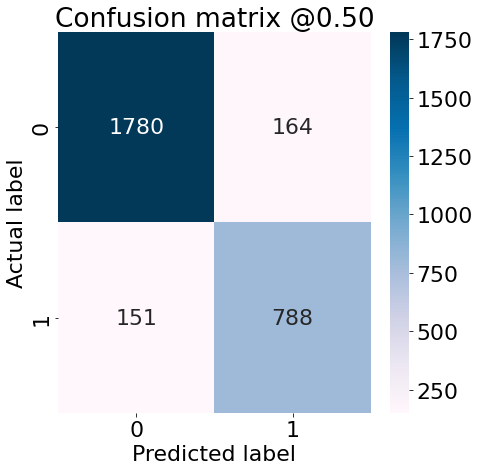

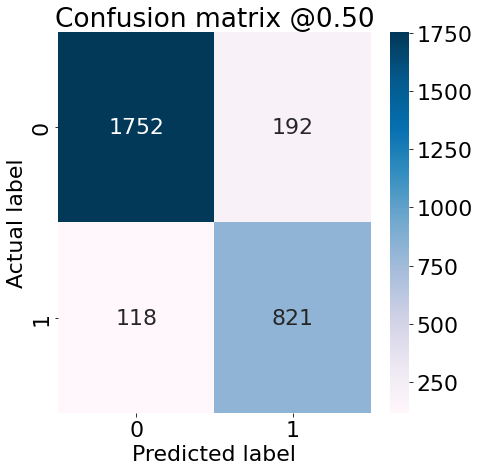

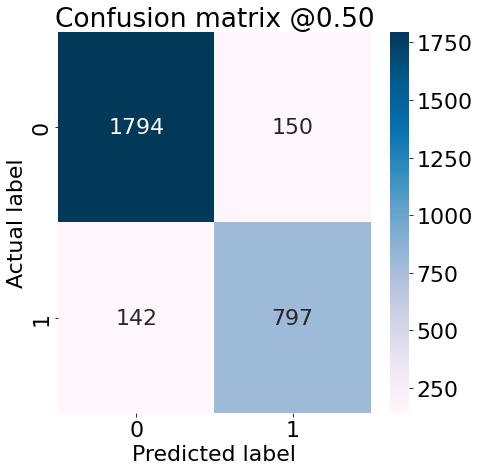

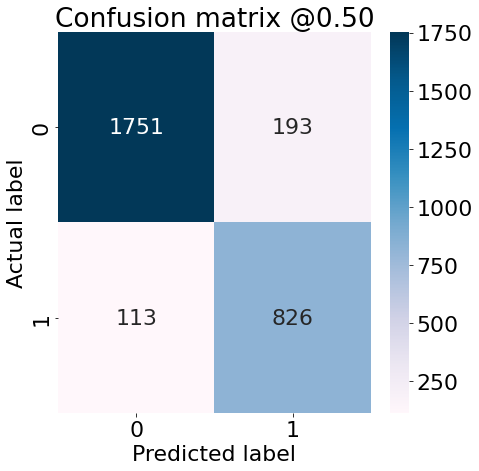

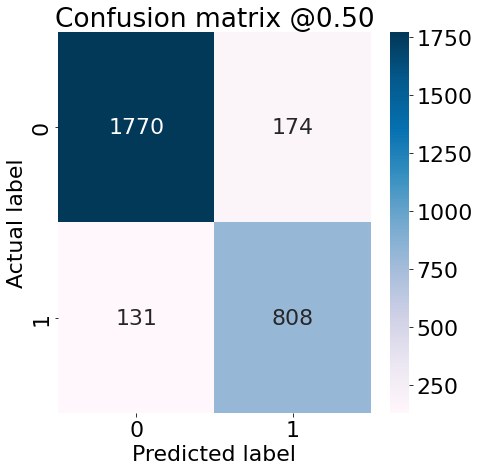

In [73]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=7
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)